In [1]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
from PIL import Image
import os
import cv2
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

sam_checkpoint = "../../SAGS/gaussiansplatting/dependencies/sam_ckpt/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

video_dir = "../../../../Downloads/tandt_db/tandt/truck/images"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
image = cv2.imread(os.path.join(video_dir, frame_names[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)



/home/verst/miniconda3/envs/myenv/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


from sam2.build_sam import build_sam2_video_predictor
from segment_anything import sam_model_registry, SamPredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"


predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
SamOnePredictor = SamPredictor(sam)

import cv2





In [3]:
image = cv2.imread("../../../../Downloads/tandt_db/tandt/truck/images/000001.jpg")
allsubmasks = []
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
i = 0
for mask in masks:
    i += 1
    print(i)
    input_point = np.array(mask["point_coords"])
    input_label = np.array([1])
    SamOnePredictor.set_image(image)
    submasks, scores, logits = SamOnePredictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    submasks = submasks[scores > 0.951]
    for tmp in submasks:
        allsubmasks.append(tmp)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


In [4]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        print(mask.shape)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
for i,tmp in enumerate(allsubmasks):
    show_masks(image, tmp, np.ones(len(tmp)), borders=True)

NameError: name 'allsubmasks' is not defined

In [5]:
unique_subs = []
for tmp in allsubmasks:
    allowed = True
    for compare in unique_subs:
        intersection = np.logical_and(tmp, compare).sum()
        union = np.logical_or(tmp, compare).sum()
        iou = 0
        if union != 0:
            iou = intersection / union
        if iou > 0.8:
            allowed = False
            break
    if allowed:
        unique_subs.append(tmp)


In [ ]:

for tmp in unique_subs:
    show_masks(image, [tmp], np.ones(len(tmp)), borders=True)

In [6]:
from dataclasses import dataclass

@dataclass
class LayeredMask:
    mask: np.ndarray
    subobjects: list['LayeredMask']

def is_contained(child, parent, threshold=0.95):
    intersection = (child & parent).sum()
    child_area = child.sum()
    return (intersection / child_area) >= threshold if child_area != 0 else False

sorted_masks = sorted(unique_subs, key=lambda m: np.count_nonzero(m), reverse=True)

layered_masks = []
mask_to_layered = []
for mask_i, mask in enumerate(sorted_masks):
    layered_obj = LayeredMask(mask,[])
    mask_to_layered.append(layered_obj)
    foundparent = False
    for bigger_j in range(mask_i-1,-1,-1):
        bigger_mask = sorted_masks[bigger_j]
        if(is_contained(mask, bigger_mask)):
            mask_to_layered[bigger_j].subobjects.append(layered_obj)
            foundparent = True
            break
    if not foundparent:
        layered_masks.append(layered_obj)


(546, 979)


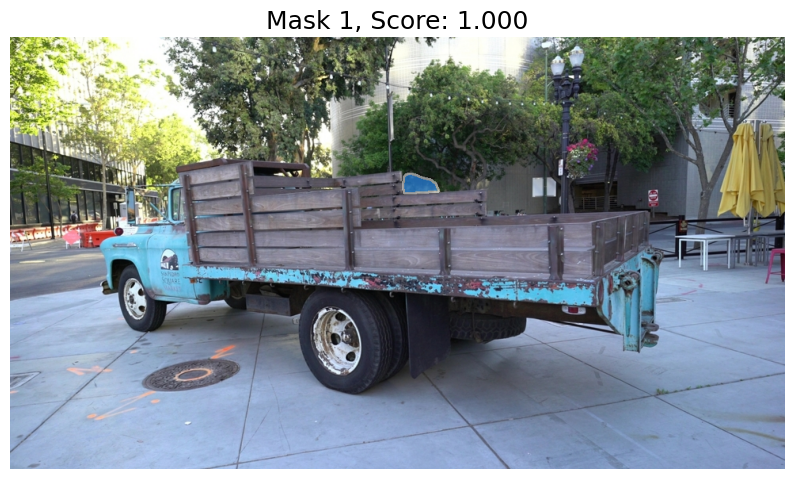

In [ ]:
for tmp in mask_to_layered:
    print('parent')
    show_masks(image, [tmp.mask], np.ones(len(tmp.mask)), borders=True)
    print('children')
    for child in tmp.subobjects:
        show_masks(image, [child.mask], np.ones(len(child.mask)), borders=True)

In [8]:



# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )


# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "../../../../Downloads/tandt_db/tandt/truck/images"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


inference_state = predictor.init_state(video_path=video_dir)
print_nr = 0

def recursiveMask(maskPrompt : LayeredMask):
    predictor.reset_state(inference_state)

    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        inference_state,
            0,
            1,
            maskPrompt.mask,
    )

    # run propagation throughout the video and collect the results in a dict
    video_segments = {'masks': {}, 'subsegments' : []}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments['masks'][out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    for subprompt in maskPrompt.subobjects:
        video_segments['subsegments'].append(recursiveMask(subprompt))

    return video_segments


layered_video_segs = []
for mask in layered_masks:
    layered_video_segs.append(recursiveMask(mask))

using device: cuda


frame loading (JPEG): 100%|██████████| 251/251 [00:18<00:00, 13.76it/s]
/mnt/c/Users/verst/projects/Masterproef/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/mnt/c/Users/verst/projects/Masterproef/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 251/251 [01:43<00:00,  2.42it/s]


In [ ]:
import pickle
import os

def save_segment_recursive(segment, path, name):
    os.makedirs(path, exist_ok=True)

    segment_to_save = {
        "masks": segment["masks"],
        "subsegments": []
    }

    for i, sub in enumerate(segment["subsegments"]):
        sub_name = f"{name}_sub{i}"
        save_segment_recursive(sub, path, sub_name)
        segment_to_save["subsegments"].append(f"{sub_name}.pkl")

    with open(os.path.join(path, f"{name}.pkl"), "wb") as f:
        pickle.dump(segment_to_save, f, protocol=pickle.HIGHEST_PROTOCOL)

def save_all_roots(roots, path):
    os.makedirs(path, exist_ok=True)
    for i, root in enumerate(roots):
        save_segment_recursive(root, path, f"root_{i}")

save_all_roots(layered_video_segs, "video_mask_tree/")


AttributeError: 'dict' object has no attribute 'mask'

: 

In [ ]:
layered_video_segs